In [2]:
import numpy as np
import scipy.stats
import msprime
import pandas as pd
import allel
import multiprocessing as mp

from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import norm

## Functions to generate simulation and observation

In [3]:
def sim_one_population(diploid_size, seq_len, rec_rate, mut_rate):
    '''simulate two populations that have diverged
        from a common ancestral population.
    Returns a tree sequence.

    @diploid_size = the population size of each population,
        also the size of the ancestral population
    @seq_len = length of the genome, units ~ base-pairs
    @rec_rate = recombination rate, units = rate per bp, per generation
    @mut_rate = mutation rate, units = rate per bp, per generation
    '''

    demography = msprime.Demography()
    demography.add_population(name="A", initial_size=diploid_size)

    ts = msprime.sim_ancestry(
        samples={'A': diploid_size},  # diploid samples
        demography=demography,
        ploidy=2,
        sequence_length=seq_len,
        discrete_genome=False,
        recombination_rate=rec_rate,
        model='dtwf',
    )

    ts = msprime.sim_mutations(
        ts,
        rate=mut_rate,
        discrete_genome=False,
        )

    return ts

In [4]:
def sample_individuals(haploid_indexes, n, replace):
    """
    return the (haploid) indexes that correspond to
    taking n diploid samples from the supplied haploid indexes

    @haploid_indexes = contiguous indexes for haploids
        should be from a single population.
    @n = the number of diploid indiviudals to take.
    """

    # ensure the haploid indexes are consecutive
    diff = np.diff(haploid_indexes)
    assert np.sum(diff == 1) == (len(haploid_indexes)-1)

    ind_indexes = haploid_indexes[::2]
    ind_samples = np.sort(np.random.choice(ind_indexes, n, replace=replace))
    haploid_samples = np.zeros(len(ind_samples)*2, dtype='int')
    haploid_samples[0::2] = ind_samples
    haploid_samples[1::2] = ind_samples+1
    return(haploid_samples)

In [5]:
def observe(ts, num_inds, max_sites):
    '''
    oberserve num_inds diploids from each population
    simplify the ts, removing non-variable sites across those individuals

    @ts = tree-sequence
    @num_inds = number of diploids to sample from each population
    @max_sites = retain at most max_sites, from among variable sites
    '''

    popA = ts.samples(population=0)
    popA_inds = sample_individuals(popA, num_inds, replace=False)
    all_inds = popA_inds
    obs_ts = ts.simplify(samples=all_inds)

    if obs_ts.num_sites > max_sites:
        all_sites = np.arange(len(obs_ts.sites()))
        sites_keep = np.random.choice(all_sites, max_sites, replace=False)
        sites_remove = np.setdiff1d(all_sites, sites_keep)
        obs_ts = obs_ts.delete_sites(sites_remove)
    return(obs_ts)

## Functions to caculate the site diversity of samples

In [6]:
def site_diversity(ac, n):
    """
    returns the diversity at one or more sites
    
    @ac = count of one of the alleles 
    @n = numer of samples
    """
       
    npairs = int(n*(n-1)/2)  # total numbers of pairs of samples
    n_different_pairs = ac * (n-ac) # number of those pairs that have different alleles
    return (n_different_pairs/npairs)

In [7]:
def get_diversity_general(ts, samples, sites_index):
    """returns average pairwise diversity of a set of samples across a set of sites. 

    This function is general in the sense that (samples) and (sites_index)may have duplicates.

    @ts = tree sequence
    @samples = the samples from the first population to be used
    @sites_index = the indexes of the sites to be used.
    """
    
    nsamples = len(samples)
    genos = obs_ts.genotype_matrix()
    diver = site_diversity(genos[sites_index, :][:,samples].sum(1), nsamples).mean()
    return diver

## Functions to obtain the confidence interval from bootstrap resample

In [8]:
def get_CI_normal(data, confidence, est_param):
    '''
    @data: estimated parameters (e.g. means of 1000 resample data)
    @confidence: width of the interval
    @est_param: value of the estimated parameter of the data that is resampled
    '''
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1) # change degree of freedom
    lower = est_param - qnorm * np.std(data, ddof=1)

    return lower, upper


def get_CI_quantile(data, confidence, est_param=None):
    
    cutoff = (1 - confidence) / 2
    lower = np.quantile(data, cutoff)
    upper = np.quantile(data, 1 - cutoff)

    return lower, upper


def get_CI_biased_corrected_norm(data, confidence, est_param=None):
    param_bar = mean(data)
    est_bias = param_bar - est_param
    est_param -= est_bias
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1)
    lower = est_param - qnorm * np.std(data, ddof=1)
    
    return lower, upper

## Functions to obtain the confidence interval from jackknife resample

In [52]:
def jk_get_CI(data, confidence):
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = mean(data) + qnorm * np.std(data, ddof=1) / sqrt(len(data)) # change degree of freedom
    lower = mean(data) - qnorm * np.std(data, ddof=1) / sqrt(len(data))

    return lower, upper

## Functions to draw plots

In [59]:
def histplot(data, pop_value, obs_value, normal, quantile, biased):
    '''
    Display the histogram of the site diversity of the resampled data and draw lines of 
    population site diversity, observed population site diversity, and three different CI.
    '''
    fig = plt.figure(dpi=180)
    sns.histplot(data)
    plt.axvline(x=obs_value, color = 'r', label = 'observe')
    #plt.axvline(x=pop_value, color = 'g', label = 'pop')
    plt.axvline(x=normal[0], color = 'b', label = 'normal')
    plt.axvline(x=normal[1], color = 'b')
    plt.axvline(x=quantile[0], color = 'm', label = 'quantile')
    plt.axvline(x=quantile[1], color = 'm')
    plt.axvline(x=biased[0], color = 'y', label = 'biased corrected')
    plt.axvline(x=biased[1], color = 'y')
    plt.legend(loc='best', fontsize = 'xx-small')
    plt.xlabel('Estimate site diversity of the resampled observed population')
    plt.show()
    

def jk_histplot(data, pop_value, obs_value, jk_CI, jk_block_CI):
    fig2 = plt.figure(dpi=150)
    sns.histplot(data)
    plt.axvline(x=obs_value, color = 'r', label = 'observe')
    #plt.axvline(x=pop_value, color = 'g', label = 'pop')
    plt.axvline(x=jk_CI[0], color = 'y', label = 'jackknife CI')
    plt.axvline(x=jk_CI[1], color = 'y')
    plt.axvline(x=jk_block_CI[0], color = 'm', label = 'jackknife block CI')
    plt.axvline(x=jk_block_CI[1], color = 'm')
    plt.legend(loc=0)
    plt.title('Histogram of site diversity from Jackknife Resample')
    plt.show()

# We observe 50 individuals and at most 5000 sites from the population and we want to use different resample methods and the observed population to estimate the site diversity of the whole population.

In [10]:
# simulation of the entire demographic history
pop_ts = sim_one_population(
    diploid_size=200,
    seq_len=1e9,
    rec_rate=1e-8,
    mut_rate=1e-8
)

obs_ts = observe(ts=pop_ts, num_inds=50, max_sites=5000)

In [11]:
pop_ts.num_samples, pop_ts.num_sites

(400, 53520)

In [12]:
obs_ts.num_samples, obs_ts.num_sites

(100, 5000)

In [13]:
pop_ts_diversity = pop_ts.diversity(span_normalise = False, windows = 'sites').mean()

obs_ts_diversity = get_diversity_general(
    ts=obs_ts,
    samples=np.arange(obs_ts.num_samples),
    sites_index=np.arange(obs_ts.num_sites),
    )

print('Site diversity for the simulated population is: ', pop_ts_diversity)
print('Site diversity for the observed population is: ', obs_ts_diversity)

Site diversity for the simulated population is:  0.1514328564778913
Site diversity for the observed population is:  0.19670933333333335


## 1. Bootstrap over sites

In [14]:
sites_res = []
for _ in range(5000):
    sites_res.append(get_diversity_general(
        ts=obs_ts,
        samples=np.arange(obs_ts.num_samples),
        sites_index=np.random.choice(obs_ts.num_sites, obs_ts.num_sites, replace = True),
    ))

In [20]:
sites_normal = get_CI_normal(data=sites_res, confidence=0.95, est_param=obs_ts_diversity)
sites_quantile = get_CI_quantile(data=sites_res, confidence=0.95)
sites_biased = get_CI_biased_corrected_norm(data=sites_res, confidence=0.95, est_param=obs_ts_diversity)

In [21]:
print('Normal CI', sites_normal, '\n')
print('Quantile CI', sites_quantile, '\n')
print('Biased Corrected Normal CI', sites_biased, '\n')

Normal CI (0.19185198945721932, 0.20156667720944738) 

Quantile CI (0.1917413676767677, 0.20164466161616162) 

Biased Corrected Normal CI (0.19185561060469408, 0.20157029835692214) 



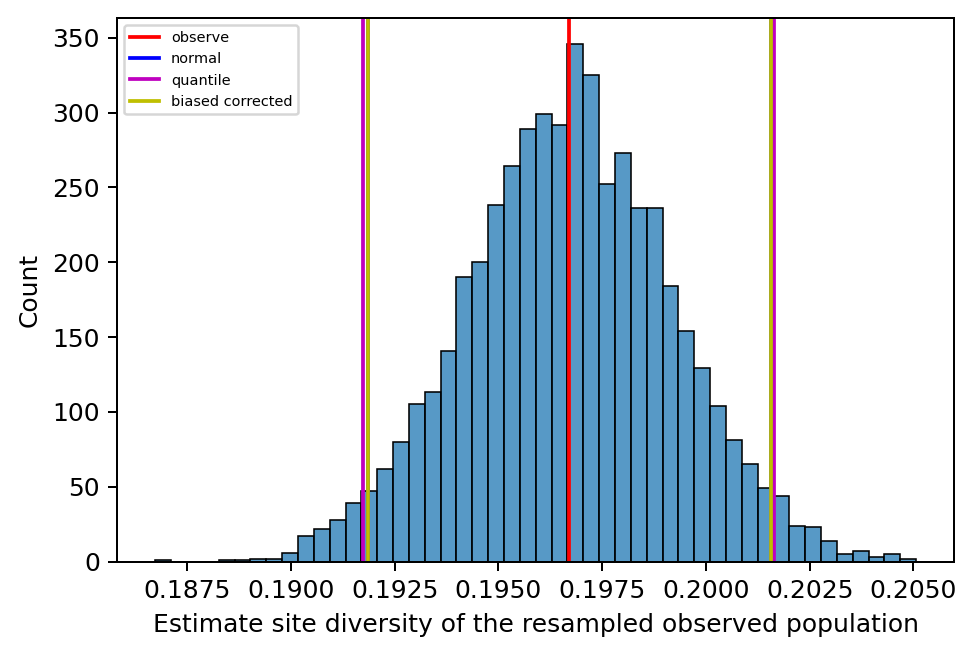

In [34]:
histplot(data=sites_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         normal=sites_normal, quantile=sites_quantile, biased=sites_biased)

## 2. Bootstrap over samples 

In [72]:
sample_res = [
    get_diversity_general(
        ts=obs_ts,
        samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
        sites_index=np.arange(obs_ts.num_sites)) for _ in range(5000)]

In [26]:
sample_normal = get_CI_normal(data=sample_res, confidence=0.95, est_param=obs_ts_diversity)
sample_quantile = get_CI_quantile(data=sample_res, confidence=0.95)
sample_biased = get_CI_biased_corrected_norm(data=sample_res, confidence=0.95, est_param=obs_ts_diversity)

In [35]:
print('Normal CI', sample_normal, '\n')
print('Quantile CI', sample_quantile, '\n')
print('Biased Corrected Normal CI', sample_biased, '\n')

Normal CI (0.19513675450279028, 0.19828191216387642) 

Quantile CI (0.19307586060606063, 0.19620890303030306) 

Biased Corrected Normal CI (0.19712307927046704, 0.20026823693155318) 



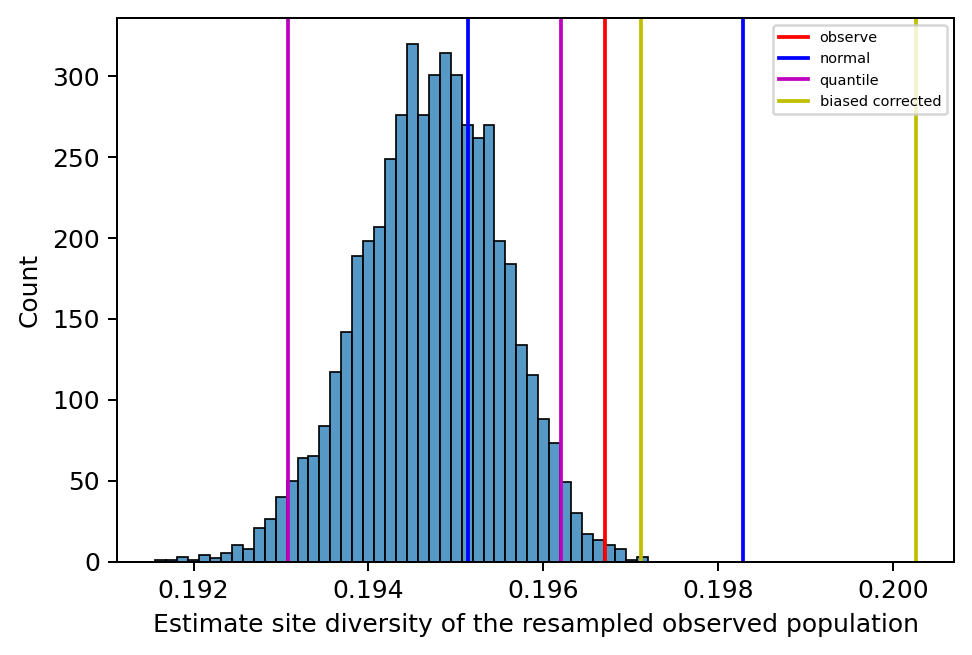

In [33]:
histplot(data=sample_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         normal=sample_normal, quantile=sample_quantile, biased=sample_biased)

## 3. Jackknife over sites

In [39]:
jk_sites_res = []
sites_index = np.arange(obs_ts.num_sites)
samples_index = np.arange(obs_ts.num_samples)

for i in range(obs_ts.num_sites):
    jk_sites_res.append(get_diversity_general(
        ts=obs_ts,
        samples=samples_index,
        sites_index=np.delete(sites_index, i)
    ))

In [65]:
kf = KFold(n_splits=50) # 100 sites in each block, total 5000 sites
jk_block_sites_res = []

for index,_ in kf.split(sites_index):
    jk_block_sites_res.append(get_diversity_general(
        ts=obs_ts,
        samples=samples_index,
        sites_index=sites_index[index]
    ))    

In [67]:
jk_sites_CI = jk_get_CI(data=jk_sites_res, confidence=0.95)
jk_block_sites_CI = jk_get_CI(data=jk_block_sites_res, confidence=0.95)
print('Jackknife CI', jk_sites_CI, '\n')
print('Block Jackknife CI', jk_block_sites_CI, '\n')

Jackknife CI (0.19670838230619198, 0.19671028436047472) 

Block Jackknife CI (0.1965951804714385, 0.1968234861952282) 



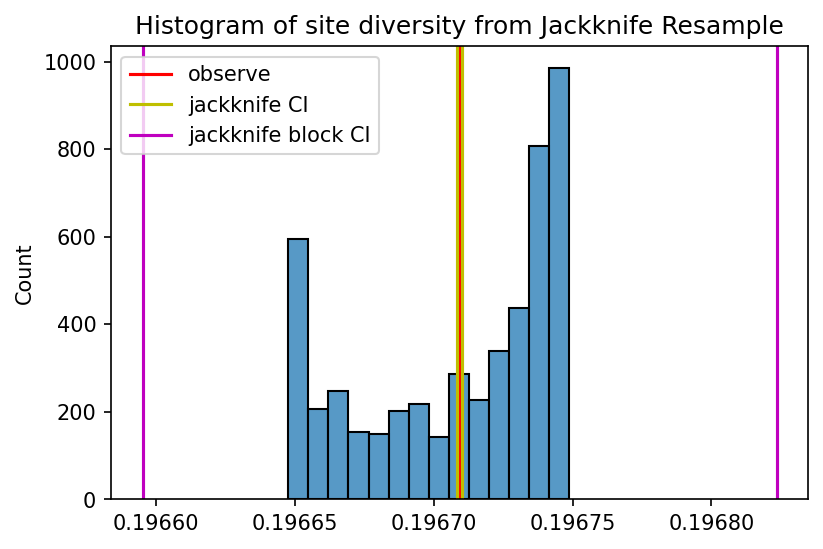

In [68]:
jk_histplot(data=jk_sites_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         jk_CI=jk_sites_CI, jk_block_CI=jk_block_sites_CI)

## 4. Jackknife over samples

In [61]:
jk_sample_res = []
samples_index = np.arange(obs_ts.num_samples)

for i in range(obs_ts.num_samples):
    jk_sample_res.append(get_diversity_general(
        ts=obs_ts,
        samples=np.delete(samples_index, i),
        sites_index=sites_index
    ))

In [63]:
jk_block_sample_res = []
kf = KFold(n_splits=20) # 10 sites in each block, total 200 samples

for index,_ in kf.split(samples_index):
    jk_block_sample_res.append(get_diversity_general(
        ts=obs_ts,
        samples=samples_index[index],
        sites_index=sites_index
    ))    

In [69]:
jk_sample_CI = jk_get_CI(data=jk_sample_res, confidence=0.95)
jk_block_sample_CI = jk_get_CI(data=jk_block_sample_res, confidence=0.95)
print('Jackknife CI', jk_sample_CI, '\n')
print('Block Jackknife CI', jk_block_sample_CI, '\n')

Jackknife CI (0.1966943262286802, 0.1967243404379865) 

Block Jackknife CI (0.19664477639340153, 0.19677712730200722) 



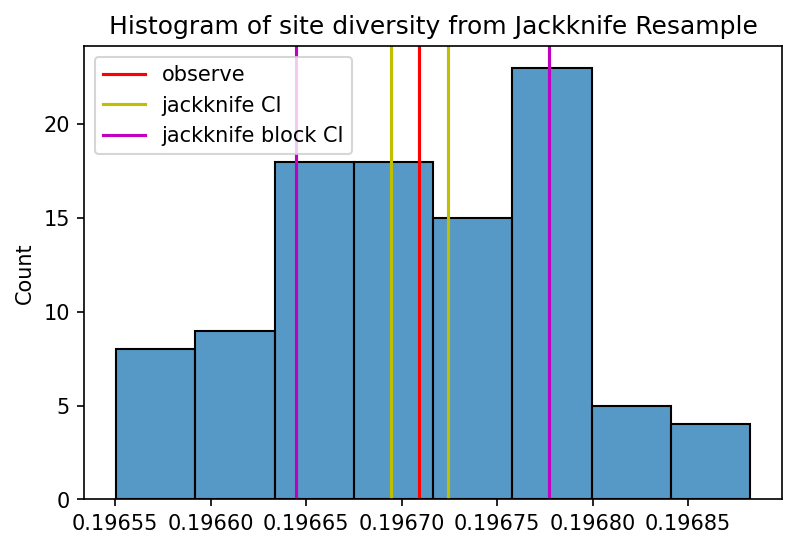

In [70]:
jk_histplot(data=jk_sample_res, pop_value=pop_ts_diversity, obs_value=obs_ts_diversity, 
         jk_CI=jk_sample_CI, jk_block_CI=jk_block_sample_CI)

# Now, we try to increase the sample size and the sites size of the observed population. 

In [76]:
samples_size = [100, 200, 300, 400]
sites_size = [5000 * i for i in range(11)]

In [77]:
samples_size

[100, 200, 300, 400]

In [78]:
sites_size

[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

In [88]:
import time 
test = np.arange(5000, dtype=np.float)

start_time = time.time()


for i in range(5000):
    test[i] = get_diversity_general(
        ts=obs_ts,
        samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
        sites_index=np.arange(obs_ts.num_sites))
    
end_time = time.time()

print("Run time = {}".format(end_time - start_time))

Run time = 200.69415879249573


In [91]:
len(test)

5000

In [94]:
import numba

SyntaxError: unexpected EOF while parsing (<ipython-input-94-002884e307c1>, line 2)

In [100]:
test = np.arange(5000, dtype=np.float)
start_time = time.time()

@numba.jit(parallel=True)


def site_diversity(ac, n):
    """
    returns the diversity at one or more sites
    
    @ac = count of one of the alleles 
    @n = numer of samples
    """
       
    npairs = int(n*(n-1)/2)  # total numbers of pairs of samples
    n_different_pairs = ac * (n-ac) # number of those pairs that have different alleles
    return (n_different_pairs/npairs)


def get_diversity_general(ts, samples, sites_index):
    """returns average pairwise diversity of a set of samples across a set of sites. 

    This function is general in the sense that (samples) and (sites_index)may have duplicates.

    @ts = tree sequence
    @samples = the samples from the first population to be used
    @sites_index = the indexes of the sites to be used.
    """
    
    nsamples = len(samples)
    genos = obs_ts.genotype_matrix()
    diver = site_diversity(genos[sites_index, :][:,samples].sum(1), nsamples).mean()
    return diver


def resample(test):
    for i in numba.prange(5000):
        test[i] = get_diversity_general(
            ts=obs_ts,
            samples=np.random.choice(obs_ts.num_samples, obs_ts.num_samples, replace = True),
            sites_index=np.arange(obs_ts.num_sites))

resample(test)
end_time = time.time()
print("Run time = {}".format(end_time - start_time)) 

Run time = 150.95386910438538
